In [25]:
# -*- coding: utf-8 -*-

import pickle
import numpy as np

import numpy as np
import sklearn
from scipy.stats import chi2 

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import BaggingClassifier

import theano.tensor as tt
import pymc3 as pm

# Unmixing Raman Spectra

### read and normalize data

We first read a bunch of _single_ mineral Raman spectra from disk into a matrix `X` and normalize them to have unit maximum.
The corresponding labels are read into a vector of integers `y`.

In [3]:
X = np.load('../data/excellent_unoriented/obs.npy')
X /= X.max(axis=0)
y = pickle.load( open( "../data/excellent_unoriented/labels.pkl", "rb" ) )
y = np.array(y)

The dataset has the following form:

In [9]:
nspecs, nfreqs = X.shape
nminerals = len(np.unique(y))
print('number of spectra', nspecs)
print('number of minerals', nminerals)
print('number of frequency samples per spectrum', nfreqs)
print('range of normalized spectra', X.min(), X.max())

number of spectra 322
number of minerals 27
number of frequency samples per spectrum 1000
range of normalized spectra -0.33042782728267744 1.0


and it looks like this:

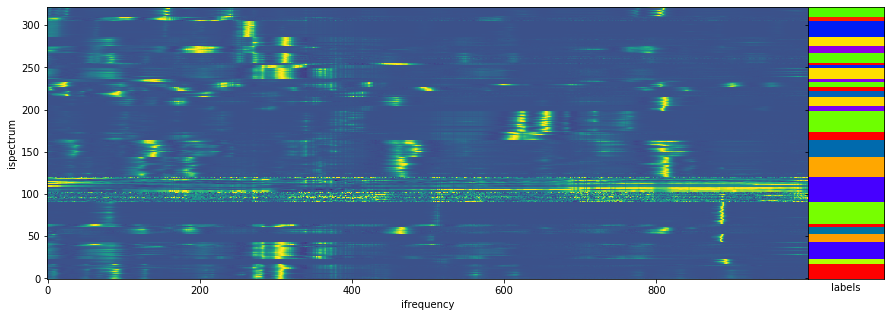

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True, gridspec_kw={'wspace': 0, 'width_ratios':[10,1]})
ax1.imshow(X, origin='lower', aspect='auto')
ax2.imshow(y[:, None], origin='lower', aspect='auto', cmap='prism')
ax2.set_xticks([])
ax1.set_xlabel('ifrequency')
ax1.set_ylabel('ispectrum')
ax2.set_xlabel('labels');

We have `322` independent spectra for `27` minerals.
This means that we have several independent measurements of the spectrum of a mineral.
Therefore, besides the _mean_ spectrum of each mineral, we also have an idea about the _variance_ that we can expect around this mean.
In this notebook, we try to exploit this information with a Bayesian approach.

The goal is to determine what minerals where present in a mixed spectrum.
Because we have some idea of the spectral variation that is to be expected, our model doesn't just describe what the _most likely_ mixed spectrum looks like but also how much deviations we expect from it.
In other word, we are setting up a probabilistic model for our data, that includes inherently stochastic elements such as a measurement error.

## compute mean spectra and variances

We will start with a simple model that describes the spectrum of each mineral as a mean spectrum with some Gaussian variation around it.
The mean and the variation of the spectra for each mineral are easy to recover:

In [12]:
mean_spectra = np.vstack([ np.mean(X[iclass==y], axis=0) for iclass in range(nminerals) ])
var_spectra = np.vstack([ np.var(X[iclass==y], axis=0) for iclass in range(nminerals) ])

They look like this:

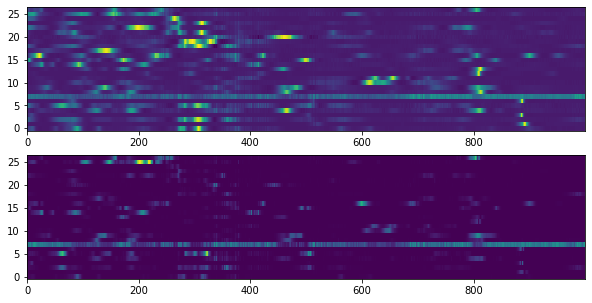

In [13]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,5))
ax1.imshow(mean_spectra, origin='lower', aspect='auto')
ax2.imshow(var_spectra, origin='lower', aspect='auto')

note that the variances (bottom plot) are not at all uniformly distributed.
We will exploit this information in the following.

## binary mixture - prepare synthetic data

Let's start with a simple binary mixture of minerals.
That is, a mineral can either occur with weight `1`, with probability `3/27` or `0` in the probe.
A random vector of `27` minerals will thus contain on average `3` minerals.
For now the sum of this vector is _unnormalized_.
Here is how we can pull `10` random mineral mixtures in this setting.

In [41]:
nsynt = 10
np.random.seed(0)
synt_y = np.random.binomial(1, p=3./27., size=(nsynt, nminerals))

We compute a mixture of minerals as a simple superposition of individual spectra from each mineral.
To get the individual spectrum, we just pick a random sample from all spectra that correspond to a specific mineral.
Let's mix:

In [42]:
synt_X = np.zeros((nsynt, nfreqs))

for isample, mixture in enumerate(synt_y):
    for imineral, weight in enumerate(mixture):
        class_spectra = X[np.array(y) == imineral]
        ispec = np.random.choice(len(class_spectra))
        synt_X[isample] += weight * class_spectra[ispec]

The mixing matrix and the associated spectra look like this:

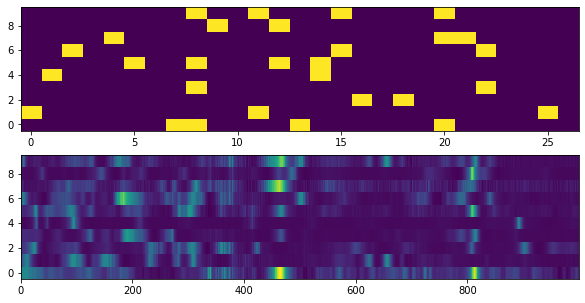

In [43]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,5))
ax1.imshow(synt_y, origin='lower', aspect='auto')
ax2.imshow(synt_X, origin='lower', aspect='auto')

here is an individual sample

mixing vector [0 0 0 0 0 1 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0]


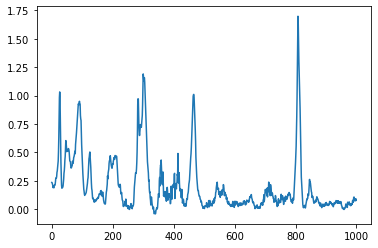

In [49]:
observation = synt_X[5]
mix = synt_y[5]
print('mixing vector', mix)
plt.plot(observation);

## binary model - inference

To infer the minerals that were present in this probe, we setup a Bayesian model and run it with PyMC3, imported on top of this notebook.
The key quantity of this Bayesian model is the _likelihood to observe a value y at frequency x, given a specific mixing vector_:

In [50]:
def logp(params):
    likelihood = -(observation - pm.math.sum(params[:, None] * mean_spectra, axis=0))**2 /pm.math.sum(0.5 * var_spectra, axis=0)
    return likelihood

Setting up the model is straight forward.
We use here a `BinaryGibbsMetropolis` sampler that corresponds to the Binary elements of the mixing vector that we have specified above.
Let's run the model:

In [51]:
with pm.Model() as model:
    params = pm.Binomial('params', n=1, p=0.5, shape=27)
    like = pm.Potential('like', logp(params))
    step = pm.BinaryGibbsMetropolis([params])
    trace = pm.sample(100, cores=10, step=step)

Only 100 samples in chain.
Multiprocess sampling (10 chains in 10 jobs)
BinaryGibbsMetropolis: [params]
Sampling 10 chains: 100%|██████████| 6000/6000 [00:03<00:00, 1978.07draws/s]


The outcome of this model is a vector of samples of mixing vectors.
Mixing vectors with a higher likelihood appear more often:

In [52]:
trace.get_values('params')

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

It becomes more obvious what this means if we plot the contents:

[Text(0.5, 1.0, 'original mixture vector of sample 2')]

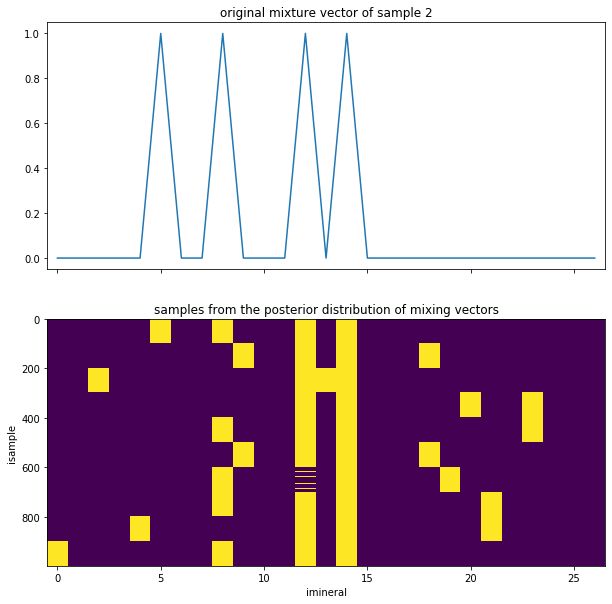

In [53]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
ax1.plot(mix)
ax2.imshow(trace.get_values('params'), aspect='auto')
ax2.set(xlabel='imineral', ylabel='isample', title='samples from the posterior distribution of mixing vectors')
ax1.set(title='original mixture vector of sample 2')

this works more or less.

## non-binary mixture

In [58]:
nsynt = 10
np.random.seed(0)
synt_y = np.abs(np.random.laplace(loc=0, scale=0.5, size=(nsynt, nminerals)))

In [59]:
synt_X = np.zeros((nsynt, nfreqs))

for isample, mixture in enumerate(synt_y):
    for imineral, weight in enumerate(mixture):
        class_spectra = X[np.array(y) == imineral]
        ispec = np.random.choice(len(class_spectra))
        synt_X[isample] += weight * class_spectra[ispec]

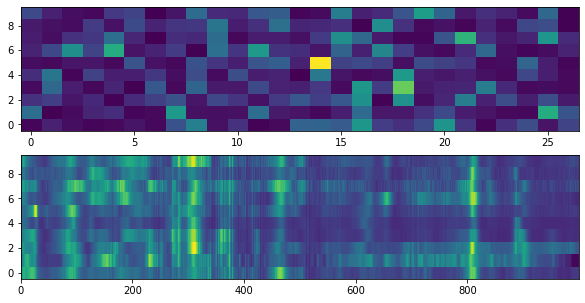

In [61]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,5))
ax1.imshow(synt_y, origin='lower', aspect='auto')
ax2.imshow(synt_X, origin='lower', aspect='auto')

mixing vector [0.05136366 0.28139179 0.11503798 0.04702699 0.08284456 0.17250606
 0.06666604 0.76518862 1.3108825  0.13271049 0.43787448 0.02976346
 0.07314283 0.95255349 0.97571024 0.87360744 1.60400757 0.54717025
 0.40631853 0.67358355 1.57603733 0.45604619 0.04008538 0.4116944
 0.72080027 0.16414235 0.62464799]


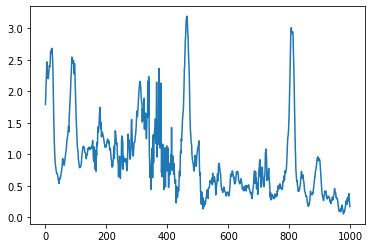

In [66]:
observation = synt_X[0]
mix = synt_y[0]
print('mixing vector', mix)
plt.plot(observation);

In [67]:
def logp(params):
    likelihood = -(observation - pm.math.sum(params[:, None] * mean_spectra, axis=0))**2 /pm.math.sum(0.5 * var_spectra, axis=0)
    return likelihood

In [68]:
with pm.Model() as model2:
    params = pm.HalfNormal('params', sigma=0.5, shape=27)
    like = pm.Potential('like', logp(params))
    trace = pm.sample(100, cores=10)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 10 jobs)
NUTS: [params]
Sampling 10 chains: 100%|██████████| 6000/6000 [00:21<00:00, 279.97draws/s]
The acceptance probability does not match the target. It is 0.8849910214996373, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8852280503105319, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8879134672433125, but should be close to 0.8. Try to increase the numbe

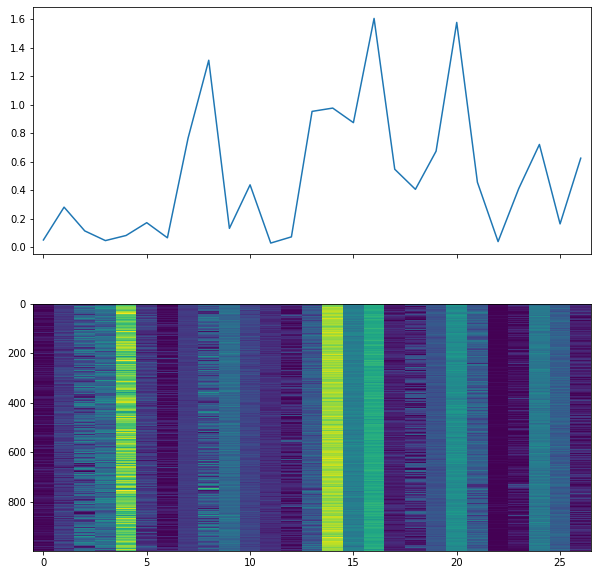

In [69]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
ax1.plot(mix)
ax2.imshow(trace.get_values('params'), aspect='auto')